## OBJECTIVE:

## Develop an advanced multi-class text classifier for ecommerce product descriptions,focusing on:

## Efficiency: Ensure fast processing for real-time categorization.
## Accuracy: Maximize categorization precision to improve customer experience.
## Scalability: Handle large volumes of diverse and ambiguous product data.
## Robustness: Accurately categorize products across multiple languages and naming conventions.

## This project aims to enhance product categorization,improving search efficiency and user experience in the eCommerce industry.



### Table of content

#### 1) Import Libraries

#### 2) Dataset preparation

#### 3) EDA

#### 4) Text Normalization

#### 4.a) Converting to Lowercase

#### 4.b) Removal of Whitespaces

#### 4.c) Removal of Punctuations

#### 4.d) Removal of Unicode Characters

#### 4.e)  Removal of Stop Words

#### 4.f)  Spelling Correction

#### 4.g) Stemming and Lemmatization

#### 4.h) Discardment of Non-alphabetic Words

#### 4.i) Retainment of Relevant Parts of Speech

#### 4.j) Workflow Integration

#### 5) Train Validation Split

#### 5.a)Test Data Setup

#### 6) TF-IDF Vectorization

#### 6.a) TF-IDF Model

#### 6.b) TF-IDF Baseline Modeling

#### 6.c) TF-IDF Hyperparameter Tuning

#### 6.d) Evaluation

#### 6.e)  Accuracy Prediction on Test Result Data

#### 7) Conclusion



In [3]:
!pip install plotly wordcloud num2words pyspellchecker spacy
!python -m spacy download en_core_web_sm
!pip install plotly wordcloud num2words pyspellchecker spacy



  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for num2words from https://files.pythonhosted.org/packages/8f/f0/ca1228af2bcbce2fdf2b23d58643c84253b88a3c1cd9dba391ca683c4b21/num2words-0.5.13-py3-none-any.whl.metadata
  Obtaining dependency information for pyspellchecker from https://files.pythonhosted.org/packages/e1/d2/c7e3b3a61a34b9320399fa731d1f9f0c73db8a1f28c6764e9e11efa68a29/pyspellchecker-0.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for spacy from https://files.pythonhosted.org/packages/39/e1/08681583569f435347ced0535b27c073fcc9a927d9b4293c963092f2d01c/spacy-3.7.5-cp311-cp311-win_amd64.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for spacy-legacy<3.1.0,>=3.0.1

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manasi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Manasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Manasi\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Manasi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [4]:
# Import Libraries
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split

import nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from num2words import num2words
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer


In [5]:
# 2) DATASET PREPARATION
# File Path:
file_path = (r'C:\Users\Manasi\Desktop\train_product_data csv.csv')
train_df = pd.read_csv(file_path)
train_df.head()


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,Footwear,SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
2,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
3,ce5a6818f7707e2cb61fdcdbba61f5ad,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FVVKRBAXHB,1199.0,479.0,"[""http://img6a.flixcart.com/image/short/p/j/z/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,29c8d290caa451f97b1c32df64477a2c,2016-03-25 22:59:23 +0000,http://www.flipkart.com/dilli-bazaaar-bellies-...,"dilli bazaaar Bellies, Corporate Casuals, Casuals",Footwear,SHOEH3DZBFR88SCK,699.0,349.0,"[""http://img6a.flixcart.com/image/shoe/b/p/n/p...",False,"Key Features of dilli bazaaar Bellies, Corpora...",No rating available,No rating available,dilli bazaaar,"{""product_specification""=>[{""key""=>""Occasion"",..."


### Reading the Data:

#### The Flipkart e-commerce product dataset that was given in a Google Sheet was first downloaded as a csv file. 
#### This dataset is to be visualised, preprocessed and read using the Pandas library.

In [6]:
train_df.isnull().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 57
discounted_price             57
image                         3
is_FK_Advantage_product       0
description                   1
product_rating                0
overall_rating                0
brand                      4710
product_specifications        6
dtype: int64

In [7]:
train_df = train_df[['description','product_category_tree']]

### Dropping unnecessary columns



In [8]:
train_df.head()

,description,product_category_tree
0,Key Features of Alisha Solid Women's Cycling S...,Clothing
1,Key Features of AW Bellies Sandals Wedges Heel...,Footwear
2,Key Features of Alisha Solid Women's Cycling S...,Clothing
3,Key Features of Alisha Solid Women's Cycling S...,Clothing
4,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear


In [9]:
train_df['description'].iloc[0]

"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_21 In the Box 3 shorts"

In [13]:
train_df.isnull().sum()

description              1
product_category_tree    0
dtype: int64

In [14]:
train_df.duplicated().sum()

1832

In [15]:
train_df.dropna(inplace = True) # Dropping observations with missing values
train_df.drop_duplicates(inplace = True) # Dropping duplicate observations
train_df.reset_index(drop = True, inplace = True) # Resetting index

In [16]:
train_df.isnull().sum()

description              0
product_category_tree    0
dtype: int64

In [17]:
train_df.duplicated().sum()

0

In [18]:
train_df.to_csv('product_clean_description.csv')

In [19]:
train_df['product_category_tree'].unique()

array(['Clothing ', 'Footwear ', 'Pens & Stationery ',
       'Bags, Wallets & Belts ', 'Home Decor & Festive Needs ',
       'Automotive ', 'Tools & Hardware ', 'Baby Care ',
       'Mobiles & Accessories ', 'Watches ', 'Toys & School Supplies ',
       'Jewellery ', 'Kitchen & Dining ', 'Computers '], dtype=object)

In [20]:
train_df['product_category_tree'].nunique()

14

In [21]:
category_mapping = {
    'Clothing ': 0,
    'Footwear ': 1,
    'Pens & Stationery ': 2,
    'Bags, Wallets & Belts ': 3,
    'Home Decor & Festive Needs ': 4,
    'Automotive ': 5,
    'Tools & Hardware ': 6,
    'Baby Care ': 7,
    'Mobiles & Accessories ': 8,
    'Watches ': 9,
    'Toys & School Supplies ': 10,
    'Jewellery ': 11,
    'Kitchen & Dining ': 12,
    'Computers ': 13
}

In [23]:
train_df['product_category_encoded'] = train_df['product_category_tree'].map(category_mapping)

### EDA

In [24]:
train_df['description_len'] = train_df['description'].apply(lambda x: len(x.split(' ')))
train_df.head()

,description,product_category_tree,product_category_encoded,description_len
0,Key Features of Alisha Solid Women's Cycling S...,Clothing,0,64
1,Key Features of AW Bellies Sandals Wedges Heel...,Footwear,1,107
2,Key Features of Alisha Solid Women's Cycling S...,Clothing,0,63
3,Key Features of Alisha Solid Women's Cycling S...,Clothing,0,65
4,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear,1,64


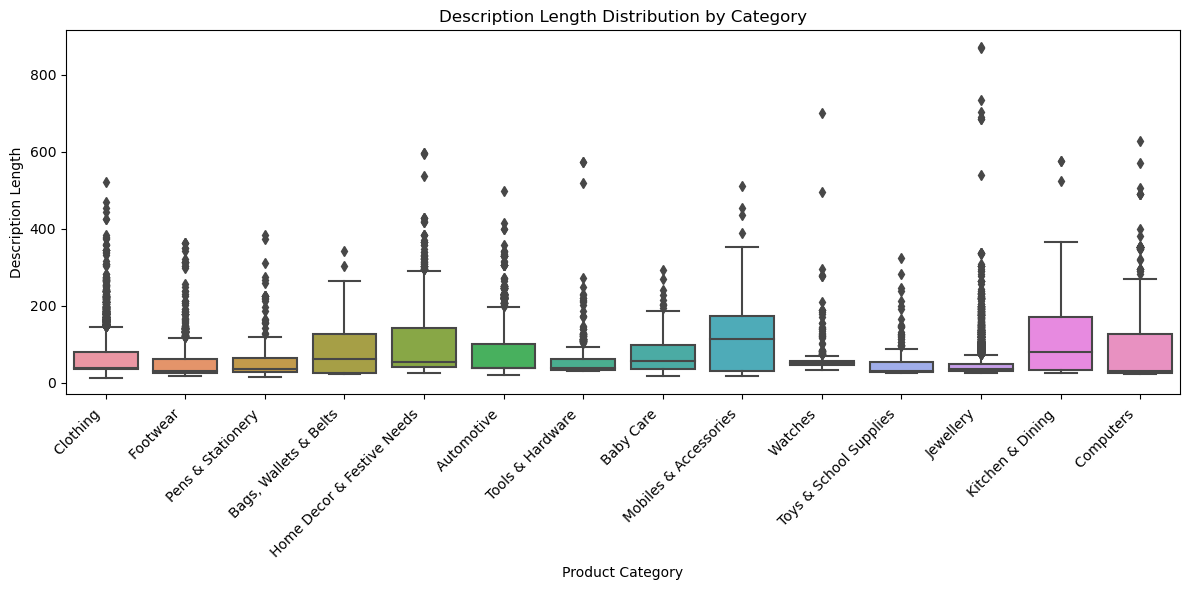

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='product_category_tree', y='description_len', data=train_df)
plt.title('Description Length Distribution by Category')
plt.xlabel('Product Category')
plt.ylabel('Description Length')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

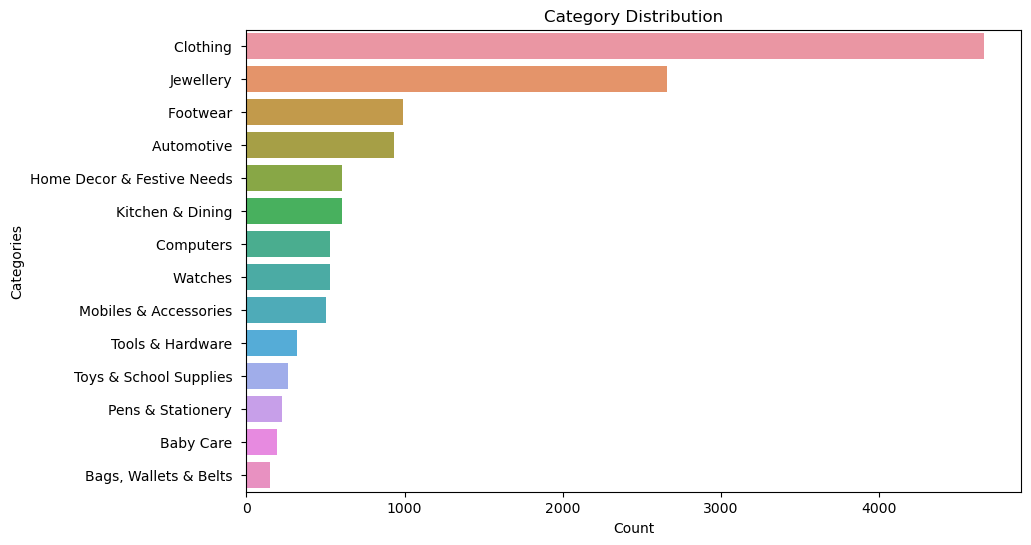

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(y="product_category_tree", data=train_df, order=train_df['product_category_tree'].value_counts().index)
plt.title('Category Distribution')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.show()

#### 4.TEXT NORMALIZATION

In [27]:
# RegexpTokenizer->RegexpTokenizer is a tool from the nltk library used to split text into smaller pieces called tokens.
regexp = RegexpTokenizer("[\w']+")

#### 4.1) Converting to Lowercase

In [28]:
# Converting to Lowercase
def convert_to_lowercase(text):
    return text.lower()

text = "How TO SOLVE product CATEGorISATION USING nlp"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))

Input: How TO SOLVE product CATEGorISATION USING nlp
Output: how to solve product categorisation using nlp


#### 4.2) Removal of whitespaces

In [29]:
# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))

Input:  	 This is a string 	 
Output: This is a string


#### 4.3) Removal of Punctuations

In [30]:
# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

text = "Here's [an] example? {of} &a string. with.? (punctuations)!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))

Input: Here's [an] example? {of} &a string. with.? (punctuations)!!!!
Output: Here's an example of a string with punctuations


#### 4.4) Removal of Unicode Characters

In [31]:
# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

text = '<a href = "https://www.xyz.com/abc/qwert"> Ecommerce Product Categorization</a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))


Input: <a href = "https://www.xyz.com/abc/qwert"> Ecommerce Product Categorization</a>
Output:  Ecommerce Product Categorization


In [32]:
# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))

Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 


In [33]:
# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))

Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
Output: It's a function that removes links starting with http: or https such as 


#### 4.5) Removal of Stopwords

In [34]:
# Stopwords
stops = stopwords.words("english") # stopwords

# Common words in English
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
             "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

# Prepositions
prepositions = ["about", "above", "across", "after", "against", "among",
                "around", "at", "before", "behind", "below", "beside", "between",
                "by", "down", "during", "for", "from", "in", "inside", "into", "near",
                "of", "off", "on", "out", "over", "through", "to", "toward", "under",
                "up", "with"]

# Less common prepositions
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but",
                            "concerning", "considering", "despite", "except", "following",
                            "like", "minus", "onto", "outside", "per", "plus", "regarding",
                            "round", "since", "than", "till", "underneath", "unlike",
                            "until", "upon", "versus", "via", "within", "without"]

# Coordinating conjunctions
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]

# Correlative conjunctions
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not",
                            "only", "but", "whether", "or"]

# Subordinating conjunctions
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as",
                              "as soon as", "as though", "because", "before", "by the time",
                              "even if", "even though", "if", "in order that", "in case",
                              "in the event that", "lest", "now that", "once", "only", "only if",
                              "provided that", "since", "so", "supposing", "that", "than",
                              "though", "till", "unless", "until", "when", "whenever", "where",
                              "whereas", "wherever", "whether or not", "while"]

# Other words
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª",
          "ûªs", "ûówe"]

# Additional stopwords
addstops = ["among","get", "onto", "shall", "thrice", "thus", "twice", "unto", "us",
            "would"]

# Common words in ecommerce contexts
common_ecommerce_words = ["shop", "shops", "shopping","buy","genuine","product",
                          "store", "stores", "day","replacement","good","description",
                           "purchase", "purchases", "checkout", "cart", "details","detail",
                           "discount", "discounts", "offer", "offers", "specification",
                           "deal", "deals", "sale", "sales", "item","items",
                           "voucher", "vouchers", "coupon", "coupons",
                           "promo", "promos", "promotion", "promotions",
                           "buying", "selling", "seller", "sellers",
                           "buyer", "buyers", "payment", "payments",
                           "checkout","free", "order", "orders","available",
                           "return", "returns", "exchange", "exchanges",
                           "refund", "refunds", "customer", "customers",
                           "service", "services", "support", "feedback",
                           "review", "reviews", "rating", "ratings",
                           "online", "offline", "delivery", "shipping",
                           "shipped", "ship", "track", "tracking","cash",
                           "payment", "prices","price","rs.","rs","select","selected",
                           "transaction", "transactions", "secure", "key","feature","features",
                           "guarantee", "guaranteed", "fast", "quick",
                           "easy", "convenient", "reliable", "trustworthy",
                           "safe", "secure", "doorstep", "discounted",
                           "affordable", "cheap", "low", "high", "best",
                           "popular", "top", "quality", "brand", "brands",
                            "stock","new", "latest", "trending", "hot", "exclusive"]

# since it is product categorization, platforms names won't help
ecommerce_platforms = ["flipkart", "amazon", "myntra","snapdeal"]


allstops = stops + alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others + addstops + common_ecommerce_words + ecommerce_platforms

print(allstops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [35]:
# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

text = "shop the latest collection of premium quality fashion accessories. get discounts on selected items. free shipping on orders over rs.50. limited stock available."
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))

Input: shop the latest collection of premium quality fashion accessories. get discounts on selected items. free shipping on orders over rs.50. limited stock available.
Output: collection premium fashion accessories 50 limited


#### 4.6) Spelling Corection

In [36]:
# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

text = "womon wetch for limitad offar"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))

Input: womon wetch for limitad offar
Output: woman watch for limited offer


In [37]:
#### 4.7) Stemming and Lemmatization

In [38]:
# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduc lemmat as an improv over stem


In [39]:
# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))

Input: Introducing lemmatization as an improvement over stemming
Output: introduce lemmatization as an improvement over stem


#### 4.8) Discardment of Non-Alphabetic words

In [40]:
# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

text = "It is a watch of Rs.1000"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))

Input: It is a watch of Rs.1000
Output: It is a watch of Rs


#### 4.9) Retainment of Relevant Parts of Speech

In [41]:
def keep_pos(text):
    # Tokenize the text
    tokens = regexp.tokenize(text)

    # Tag the tokens with POS tags
    tokens_tagged = nltk.pos_tag(tokens)

    # Define the POS tags to keep
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS',   # Nouns
                 'JJ', 'JJR', 'JJS',          # Adjectives
                 'RB', 'RBR', 'RBS',          # Adverbs
                 'VB', 'VBD', 'VBG', 'VBN',   # Verbs
                 'FW']                        # Foreign words

    # Keep words with specified POS tags
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]

    # Join the kept words into a string
    return " ".join(keep_words)

In [42]:
# Example product description
product_description = "This stylish red dress is perfect for parties and special occasions. Made with high-quality fabric, it features a flattering fit and flare silhouette. Pair it with heels and statement jewelry for a stunning look."

# Apply the keep_pos function to the product description
filtered_description = keep_pos(product_description)

print("Input: {}".format(product_description))
print("Output: {}".format(filtered_description))

Input: This stylish red dress is perfect for parties and special occasions. Made with high-quality fabric, it features a flattering fit and flare silhouette. Pair it with heels and statement jewelry for a stunning look.
Output: stylish red dress perfect parties special occasions Made high quality flattering fit flare silhouette Pair heels statement jewelry stunning look


#### 4.10) Workflow Integration

In [43]:
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub(r'\.com\b', '', text) # Remove ".com"
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
#     text = pyspellchecker(text)
    text = text_lemmatizer(text) # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_stopwords(text)
    return text

In [44]:
text = " We'll (combine) women's [all] {functions}  into 1 - /SINGLE FUNCTION 🙂 & apply on watch T-shirt plastic pan @product #descriptions https://en.wikipedia.org/wiki/Text_normalization free offer on flip-kart.com Rs 100"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))

Input:  We'll (combine) women's [all] {functions}  into 1 - /SINGLE FUNCTION 🙂 & apply on watch T-shirt plastic pan @product #descriptions https://en.wikipedia.org/wiki/Text_normalization free offer on flip-kart.com Rs 100
Output: combine woman function single function apply watch tshirt plastic pan


In [46]:
train_df['normalized_description'] = train_df['description'].apply(text_normalizer)

KeyboardInterrupt: 

In [47]:
train_df['normalized_description'] = train_df['description'].apply(text_normalizer)

In [48]:
train_df[['description','normalized_description']]

,description,normalized_description
0,Key Features of Alisha Solid Women's Cycling S...,alisha solid woman cycling short cotton navy r...
1,Key Features of AW Bellies Sandals Wedges Heel...,aw belly sandal wedge heel casualsaw belly mat...
2,Key Features of Alisha Solid Women's Cycling S...,alisha solid woman cycling short cotton black ...
3,Key Features of Alisha Solid Women's Cycling S...,alisha solid woman cycling short cotton navy r...
4,"Key Features of dilli bazaaar Bellies, Corpora...",dilli bazaaar belly corporate casual casual ma...
...,...,...
13161,Thelostpuppy Book Cover for Apple iPad Air 2 (...,thelostpuppy book cover apple ipad air multico...
13162,Babes Brass Cuff (Pack of 2)\n ...,babes cuff pack babe present special combo gif...
13163,Kenway Retail Brass Copper Cuff\n ...,kenway retail brass copper cuff sultry swagger...
13164,Kenway Retail Brass Copper Cuff\n ...,kenway retail brass copper cuff swagger sexy s...


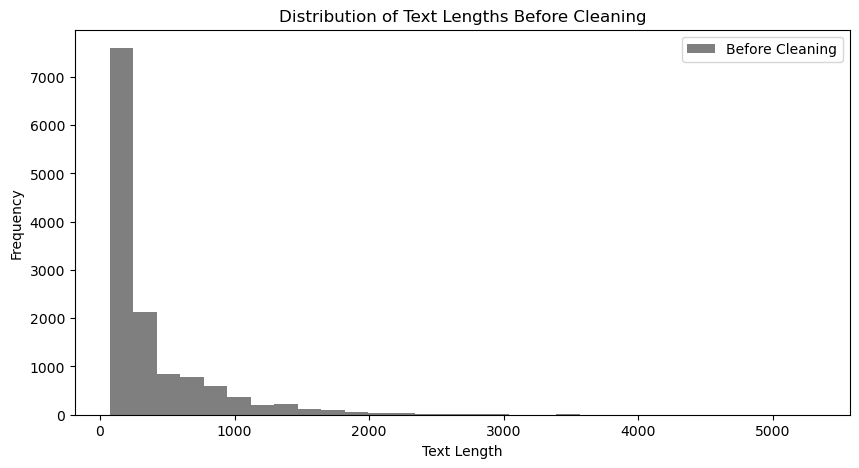

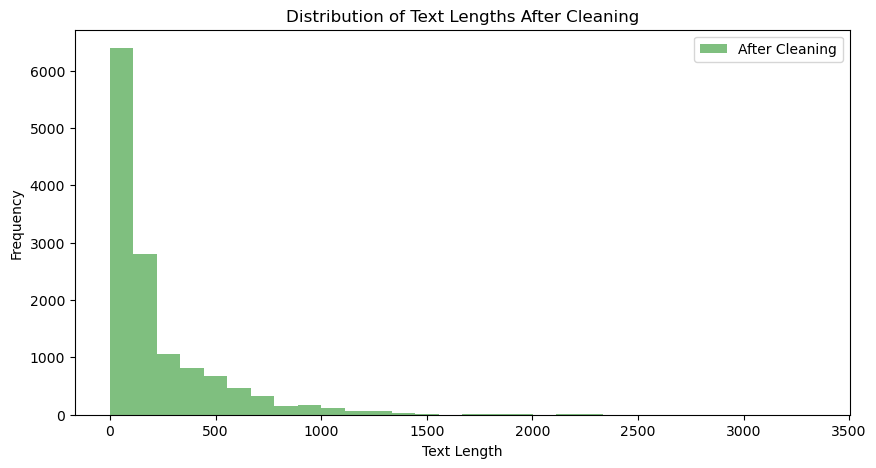

In [49]:
# Before cleaning
plt.figure(figsize=(10, 5))
plt.hist(train_df['description'].str.len(), bins=30, color='black', alpha=0.5, label='Before Cleaning')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths Before Cleaning')
plt.legend()
plt.show()

# After cleaning
plt.figure(figsize=(10, 5))
plt.hist(train_df['normalized_description'].str.len(), bins=30, color='green', alpha=0.5, label='After Cleaning')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths After Cleaning')
plt.legend()
plt.show()

In [50]:
# Calculating average text lengths before and after cleaning
avg_text_length_before = train_df['description'].str.len().mean()
avg_text_length_after = train_df['normalized_description'].str.len().mean()

# Calculating the percentage reduction in text length
percentage_reduction = ((avg_text_length_before - avg_text_length_after) / avg_text_length_before) * 100

print("Percentage reduction in text length after cleaning: {:.2f}%".format(percentage_reduction))

Percentage reduction in text length after cleaning: 44.75%


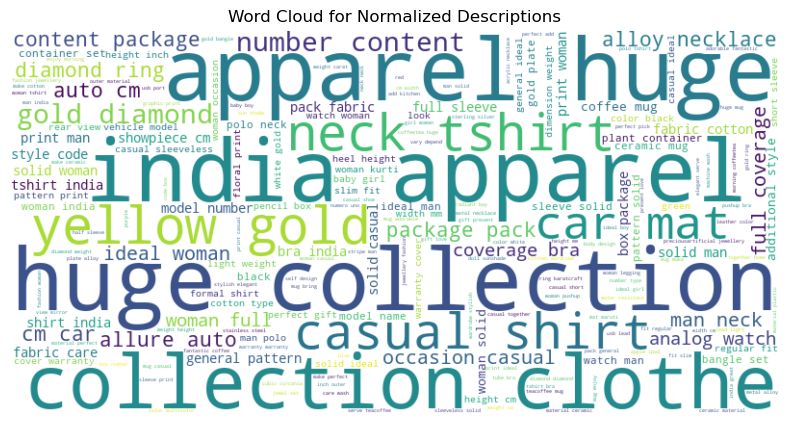

In [51]:
text = " ".join(description for description in train_df['normalized_description'])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud for Normalized Descriptions')
plt.show()

#### 5) Train Validation Split

In [53]:
X = train_df['normalized_description']
y = train_df['product_category_encoded']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("Training data: " ,len(X_train), len(y_train))
print("Validation data: ",len(X_val), len(y_val))

Training data:  10532 10532
Validation data:  2634 2634


#### 5.1) Test-data Setup

In [54]:
test_df = pd.read_csv(r"C:\Users\Manasi\Desktop\test_data csv.csv")

In [55]:
print("Testing data without label: ",test_df.shape)

Testing data without label:  (2534, 14)


In [56]:
X_test = test_df['description'].apply(text_normalizer)

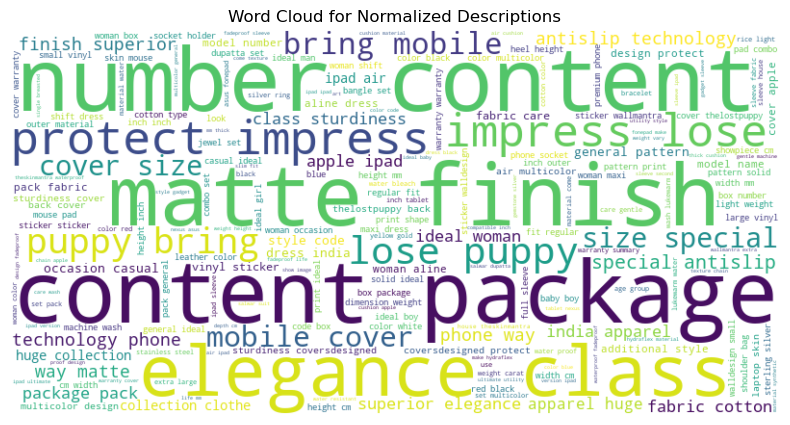

In [58]:
from wordcloud import WordCloud

text = " ".join(description for description in X_test)

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud for Normalized Descriptions')
plt.show()

#### 6) TF-IDF Vectorization

#### TF-IDF Workflow:

#### 6.1) TF-IDF Model

In [59]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train)
X_val_tfidf = TfidfVec.transform(X_val)
X_test_tfidf = TfidfVec.transform(X_test)

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score

In [63]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/e2/7b/8c1b410cd0604cee9a167a19f7e1746f5b92ae7d02ad574ab560b73c5a48/xgboost-2.1.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 487.6 kB/s eta 0:04:17
   ---------------------------------------- 0.1/124.9 MB 930.9 kB/s eta 0:02:15
   ---------------------------------------- 0.1/124.9 MB 930.9 kB/s eta 0:02:15
   ---------------------------------------- 0.1/124.9 MB 930.9 kB/s eta 0:02:15
   ---------------------------------------- 0.2/124.9 MB 1.0 MB/s eta 0:02:05
   ---------------------------------------- 0.3/124.9 MB 1.1 MB/s eta 0:01:51
   ---------------------------------------- 0.4/124.9 MB 1.3 MB/s eta 0:01:36
   ---------------------------------------- 0.6/124.9 MB 1.5 MB/s eta 0:01:23
   ------------------

#### TF-IDF Baseline Modeling

In [65]:
# Classifiers
names = [
    "MultinomialNB",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "Ridge Classifier",
    "XGBoost",
    "AdaBoost",
]

models = [
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
    DecisionTreeClassifier(),
    svm.SVC(kernel = 'linear'),
    RandomForestClassifier(n_estimators = 100),
    SGDClassifier(loss = 'hinge'),
    RidgeClassifier(),
    XGBClassifier(),
    AdaBoostClassifier()
]

In [66]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names = names, models = models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [67]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)

,Classifier,Training accuracy,Validation accuracy
6,Ridge Classifier,0.993449,0.982536
5,SGD Classifier,0.991455,0.980638
3,Linear SVM,0.991834,0.979879
7,XGBoost,0.997341,0.973424
4,Random Forest,0.999145,0.970767
2,Decision Tree,0.999145,0.964313
0,MultinomialNB,0.924326,0.909643
1,KNN Classifier,0.899734,0.900911
8,AdaBoost,0.498671,0.500380


#### 6.3) TF-IDF Hyperparameter Tuning

In [68]:
#We will perform hyperparameter tuning on the best performing baseline model.

In [69]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='accuracy', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid.
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters.
    The combination with the highest accuracy for each class is selected as the default scoring metric.
    The function returns the classifier with the optimal hyperparameters.
    '''

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [70]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score,roc_auc_score,confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [71]:
# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10, 100],        # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'], # Solvers
    'class_weight':[None, 'balanced']                 # Whether to normalize the input features
}

In [72]:
best_ridge, best_hyperparams = tune_clf_hyperparameters(RidgeClassifier(), param_grid, X_train_tfidf, y_train)
print('Optimal Hyperparameters: \n',  best_hyperparams)

Optimal Hyperparameters: 
 {'alpha': 1.0, 'class_weight': 'balanced', 'solver': 'auto'}


#### 6.4) Evaluation

In [73]:
# Reverse the category mapping to map numeric labels back to category names
reverse_category_mapping = {v: k.strip() for k, v in category_mapping.items()}

def map_labels(y, reverse_mapping):
    return [reverse_mapping[label] for label in y]

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Map numeric labels to category names
    y_train_mapped = map_labels(y_train, reverse_category_mapping)
    y_test_mapped = map_labels(y_test, reverse_category_mapping)

    # Predict using the model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Map numeric predictions to category names
    y_train_pred_mapped = map_labels(y_train_pred, reverse_category_mapping)
    y_test_pred_mapped = map_labels(y_test_pred, reverse_category_mapping)

    # Evaluate the model on the train data
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train_mapped, y_train_pred_mapped))

    # Evaluate the model on the test data
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test_mapped, y_test_pred_mapped))

    # Generate confusion matrix
    cm = confusion_matrix(y_test_mapped, y_test_pred_mapped, labels=list(reverse_category_mapping.values()))

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(14, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=list(reverse_category_mapping.values()),
                yticklabels=list(reverse_category_mapping.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.show()


	  Classification report for training set
-------------------------------------------------------
                            precision    recall  f1-score   support

                Automotive       1.00      1.00      1.00       748
                 Baby Care       0.85      1.00      0.92       156
     Bags, Wallets & Belts       1.00      1.00      1.00       122
                  Clothing       1.00      0.99      1.00      3730
                 Computers       1.00      0.97      0.99       423
                  Footwear       0.98      1.00      0.99       790
Home Decor & Festive Needs       1.00      1.00      1.00       485
                 Jewellery       1.00      1.00      1.00      2126
          Kitchen & Dining       1.00      1.00      1.00       485
     Mobiles & Accessories       1.00      1.00      1.00       401
         Pens & Stationery       0.99      0.94      0.96       179
          Tools & Hardware       1.00      1.00      1.00       257
    Toys & Schoo

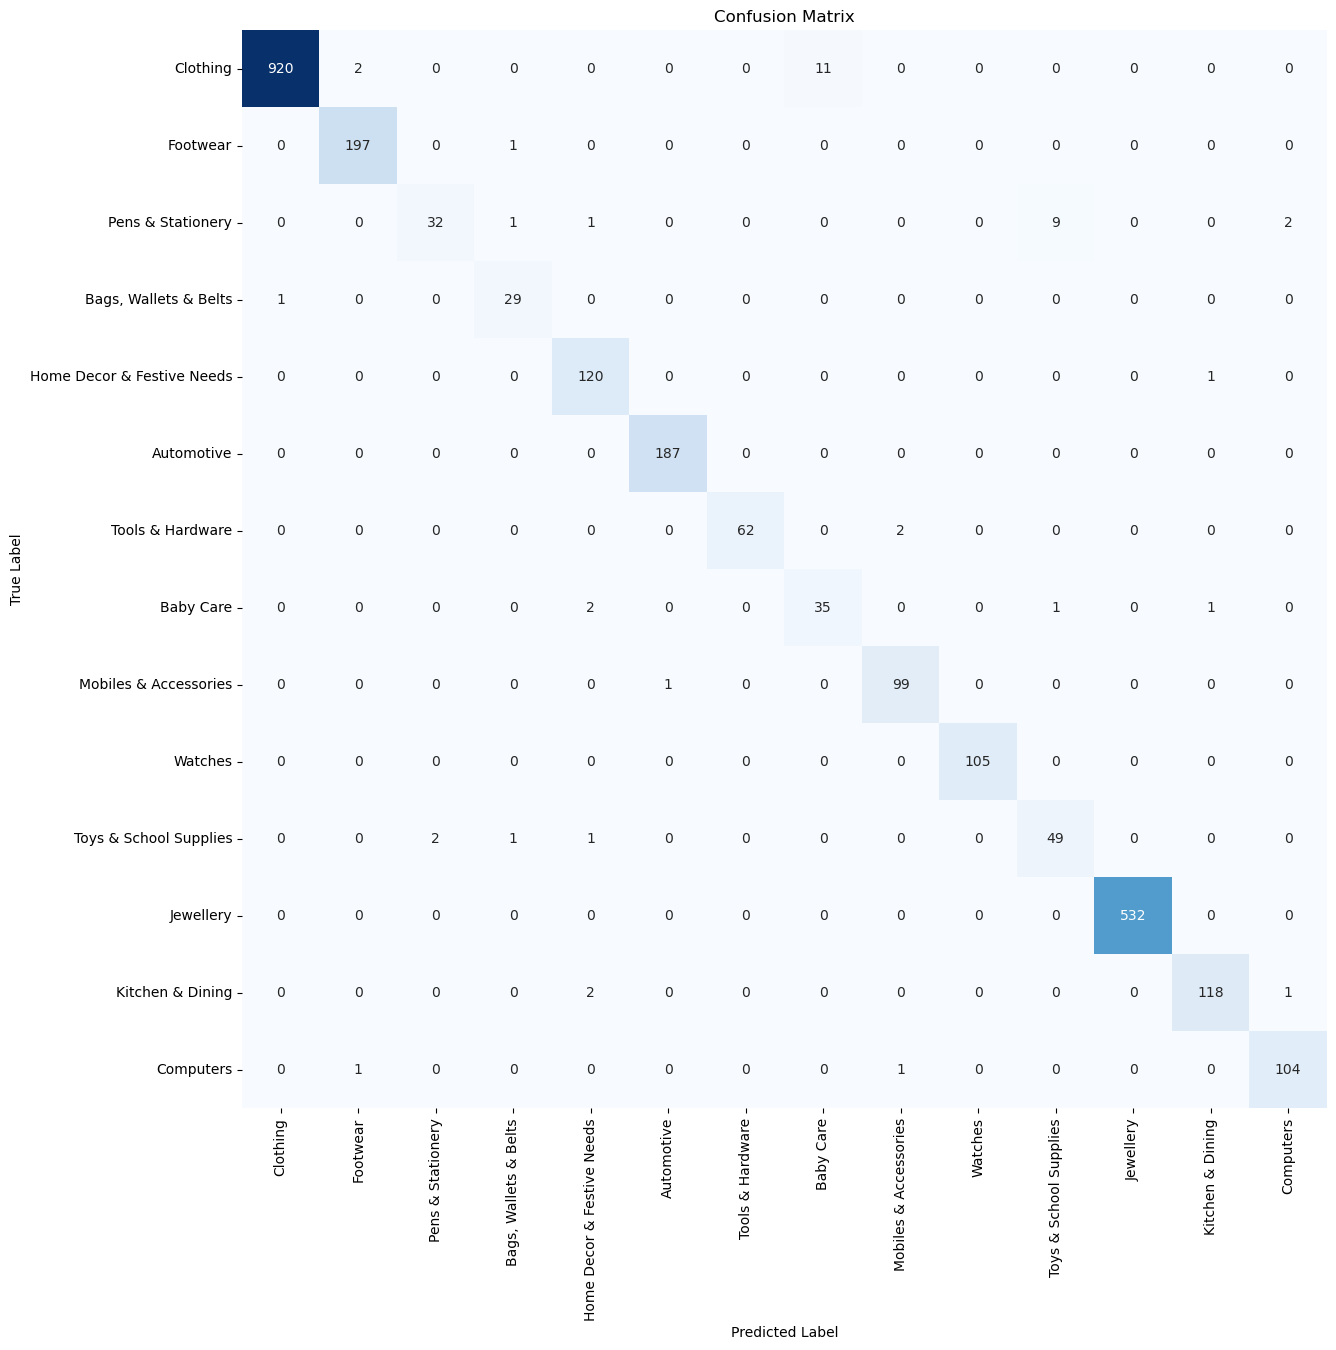

In [74]:
evaluate_model(best_ridge, X_train_tfidf, y_train, X_val_tfidf, y_val)

#### E-commerce Product Categorization Performance:

#### Training Set:

#### Test Set:

#### 6.5) Accuracy Prediction on Test Result Data

In [77]:
test_result = pd.read_csv(r"C:\Users\Manasi\Desktop\test_results csv.csv")
test_result.shape

(2534, 1)

In [78]:
y_test_pred = best_ridge.predict(X_test_tfidf)

In [79]:
test_result.isnull().sum()

product_category_tree    0
dtype: int64

In [80]:
type(y_test_pred)

numpy.ndarray

In [81]:
category_mapping = {
    'Clothing ': 0,
    'Footwear ': 1,
    'Pens & Stationery ': 2,
    'Bags, Wallets & Belts ': 3,
    'Home Decor & Festive Needs ': 4,
    'Automotive ': 5,
    'Tools & Hardware ': 6,
    'Baby Care ': 7,
    'Mobiles & Accessories ': 8,
    'Watches ': 9,
    'Toys & School Supplies ': 10,
    'Jewellery ': 11,
    'Kitchen & Dining ': 12,
    'Computers ': 13
}

y_test = test_result['product_category_tree'].map(category_mapping)

In [82]:
y_test = np.array(y_test)

In [83]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8583


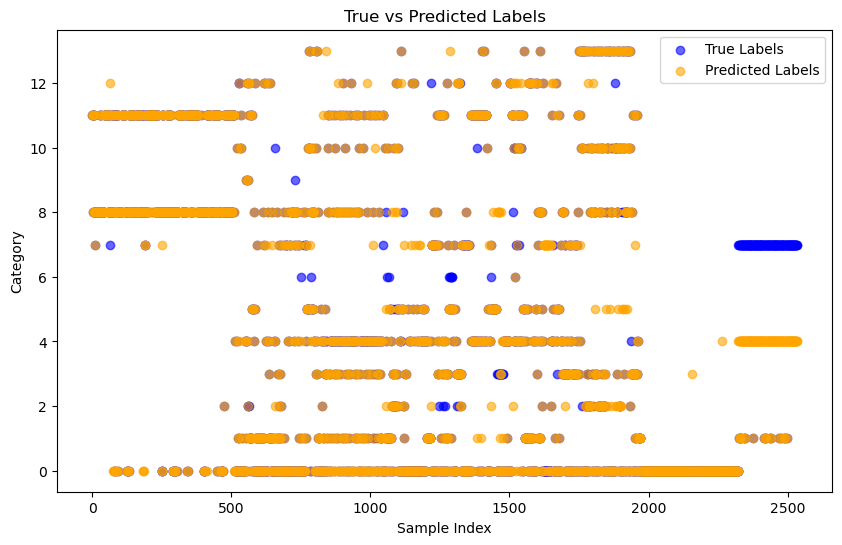

In [86]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Labels', alpha=0.6)
plt.scatter(range(len(y_test_pred)), y_test_pred, color='orange', label='Predicted Labels', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Category')
plt.title('True vs Predicted Labels')
plt.legend()
plt.show()


#### 7) Conclusion

#### Future Work:

In [87]:
#Deployment

In [88]:
import joblib

# Save the model
joblib.dump(best_ridge, 'best_ridge_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(TfidfVec, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']